Import thư viện


In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from imutils import paths
import seaborn as sns
import random
import time
from datetime import datetime

Thư viện cho image pre-processing and classification:


In [2]:
import cv2
import joblib
from skimage.feature import hog
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

In [3]:
def load_images(image_paths):

    for (i, image_path) in enumerate(image_paths):
        #read image
        image = cv2.imread(image_path)
        image = np.array(image).astype('uint8') 
        image = cv2.resize(image, (64, 64))
        grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        hog_features, hog_images = hog(grey_image,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))
        #label image using the annotations
        label = class_object.index(annotations["annotations"][image_path[7:]][0]['label'])
        train_images.append(hog_features)
        train_labels.append(label)


In [13]:
import json

# Đọc nội dung của tệp annotation.json
with open('images/_annotations.json', 'r') as file:
    annotations = json.load(file)

In [14]:
first_five = {k: annotations["annotations"][k] for k in list(annotations["annotations"])[:5]}
first_five

{'645c2283-a71c-42ee-a841-3a696018eef8.jpg': [{'label': 'dog'}],
 'e95d9b59-1dd8-4747-abb9-bde400b7d25e.jpg': [{'label': 'dog'}],
 'e9d94988-099a-48e9-b6ad-bd939d0b92c0.jpg': [{'label': 'dog'}],
 '1710540b-b4dd-4697-bb7a-8e423fb05b1c.jpg': [{'label': 'dog'}],
 '4dc102a8-4d32-4870-9793-7d1199e33c97.jpg': [{'label': 'dog'}]}

In [15]:
sample_image = 'images/' + random.choice(list(annotations["annotations"].keys()))

In [16]:
sample_image = cv2.imread(sample_image)

In [17]:
sample_image = cv2.resize(sample_image, (64, 64))
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2GRAY)

Plot the data to look at what it looks like:


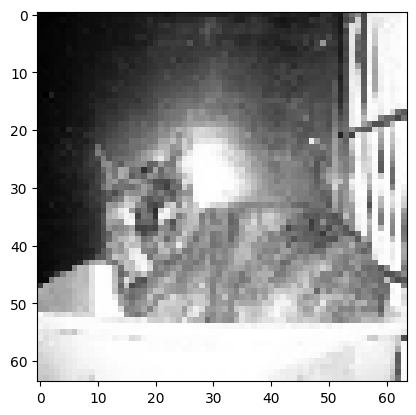

In [18]:
plt.imshow(sample_image, cmap=plt.cm.gray)

Run H.O.G. on the grayscale image to see what it will look like.

H.O.G. stands for Histogram of Oriented Gradients. It uses the gradient orientation of the localized regions of an image and generates a histogram for each localized region.


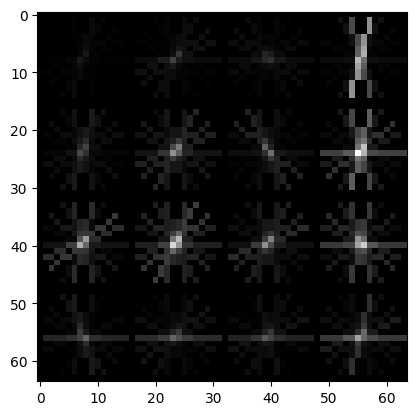

In [19]:
## when we run H.O.G., it returns an array of features and the image/output it produced
## the featurre is what we use to train the SVM model
sample_image_features, sample_hog_image = hog(sample_image,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))

## lets look at what the H.O.G. feature looks like
plt.imshow(sample_hog_image, cmap=plt.cm.gray)

## Load Images and Generate Training/Testing Dataset


Initiate a location for saving loaded images:


In [20]:
image_paths = list(paths.list_images('images'))
train_images = []
train_labels = []
class_object = annotations['labels']

Use the function on the image path:


In [21]:
load_images(image_paths)

Create an array of the images and use the <code>np.vstack</code> to vertically stack arrays for wrangling.


In [22]:
train_array = np.array(train_images)
train_array = np.vstack(train_array)

We will <code>reshape</code> the array to <code>(label size, 1)</code>. The array will look like this: <code>[[1], [0], ..., [0]]</code></p>


In [23]:
labels_array = np.array(train_labels)

In [24]:
labels_array = labels_array.astype(int)
labels_array = labels_array.reshape((labels_array.size,1))

Concatenate the images and labels:


In [25]:
train_df = np.concatenate([train_array, labels_array], axis = 1)

Divide the data into a training and test set:


In [26]:
percentage = 75
partition = int(len(train_df)*percentage/100)

In [27]:
x_train, x_test = train_df[:partition,:-1],  train_df[partition:,:-1]
y_train, y_test = train_df[:partition,-1:].ravel(), train_df[partition:,-1:].ravel()

## Hyperparameters


The kernel type to be used is a hyperparameter. The most common kernels are <code>RBF</code>, <code>poly</code>, or <code>sigmoid</code>. You can also create your own kernel.

<code>C</code> behaves as a regularization parameter in the SVM. The <code>C</code> parameter trades off correct classification of the training examples against the maximization of the decision function’s margin. For larger values of <code>C</code>, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. A lower <code>C</code> will encourage a larger margin, therefore a simpler decision function at the cost of accuracy. We select C and the best kernel by using the validation data. 


The  python dictionary <code>param_grid</code>  has different kernels and values of C. We can test them using the validation data.


In [28]:
param_grid = {'kernel': ('linear', 'rbf'),'C': [1, 10, 100]}

<code>gamma</code> is a parameter of the RBF kernel and can be thought of as the spread of the kernel and, therefore, the decision region. Low values mean ‘far’ and high values mean ‘close’. The behaviour of the model is very sensitive to the gamma parameter. If gamma is too large, the radius of the area of influence of the support vectors only includes the support vector itself. We create a Support Vector Classification object.


## Support Vector Machines


In [29]:
base_estimator = SVC(gamma='scale')

We will train the model and try different kernels and parameter values using the function <code>GridSearchCV</code>. The resulting output will be the model that performs best on the validation data. 


In [30]:
start_datetime = datetime.now()
start = time.time()

svm = GridSearchCV(base_estimator, param_grid, cv=5)
#Fit the data into the classifier
svm.fit(x_train,y_train)
#Get values of the grid search
best_parameters = svm.best_params_
print(best_parameters)
#Predict on the validation set
y_pred = svm.predict(x_test)
# Print accuracy score for the model on validation  set. 
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))

end = time.time()
end_datetime = datetime.now()
print(end - start)

{'C': 10, 'kernel': 'rbf'}
Accuracy: 0.56
0.324887752532959


**A Quick Guide to the Confusion Matrix**


Get Confusion Matrix for SVM results:


In [31]:
label_names = [0, 1]
cmx = confusion_matrix(y_test, y_pred, labels=label_names)

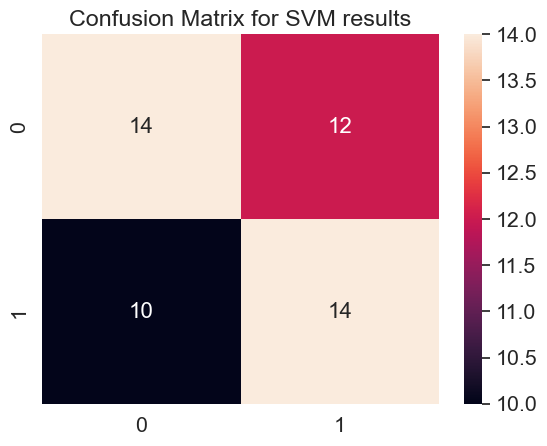

In [32]:
df_cm = pd.DataFrame(cmx)
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
title = "Confusion Matrix for SVM results"
plt.title(title)
plt.show()

In [35]:
parameters = {
    'best_params': best_parameters
}
parameters

{'best_params': {'C': 10, 'kernel': 'rbf'}}

In [36]:
# Save the SVM model to a file
joblib.dump(svm.best_estimator_, 'svm.joblib')

['svm.joblib']